In [1]:
using CSV, DataFrames, Gadfly, Distributions, SparseArrays, LinearAlgebra

include("GMRF.jl");
include("grid.jl");
include("gibbs.jl");

# Création de la grille à 9 cellules

Chaque cellule est représentée par un triplet $[\mu, \sigma, \xi]$ indiquant les vraie valeur des paramètres de la GEV à déterminer.

In [2]:
# Seed
Random.seed!(400)
# Dimensions de la grille
m₁ = 3;
m₂ = 3;
# Nb total de cellules
m = m₁ * m₂
# Insuffisance de rang de la matrice de structure
r = 1;
# Hyperparamètres
κᵤ = 100.0;
# Matrice de structure
F = iGMRF(m₁, m₂, κᵤ);

In [3]:
grid_target = generateTargetGridV1(F);

In [4]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 0.0211641   0.0153844   -0.117718
 0.077531    0.00983722  -0.0508229
 0.0955774  -0.0244998   -0.0264531

# Génération de données

Le but est de générer des données sur chaque cellule à partir des paramètres de la GEV de la grille cible.

In [5]:
nobs = 1000
data = generateData(grid_target, nobs);

# Modèle 

In [24]:
include("gibbs.jl");

niter = 10000
δ² = 0.07
κᵤ₀ = 10
μ₀ = zeros(m)
W = buildStructureMatrix(m₁, m₂);

κᵤ, μ = gibbs(niter, data, δ²=δ², κᵤ₀=κᵤ₀, μ₀=μ₀, W=W);

θ = vcat(reshape(κᵤ, 1, niter), μ)

μ = θ[2:end, :];
κᵤ = θ[1, :];

μ̂ = mean(θ[2:end, :], dims=2);
κ̂ᵤ = mean(θ[1, :]);


Taux d'acceptation μ1: 40.35 %
Taux d'acceptation μ2: 39.32 %
Taux d'acceptation μ3: 40.5 %
Taux d'acceptation μ4: 38.99 %
Taux d'acceptation μ5: 37.15 %
Taux d'acceptation μ6: 39.14 %
Taux d'acceptation μ7: 41.4 %
Taux d'acceptation μ8: 39.39 %
Taux d'acceptation μ9: 41.45 %


In [25]:
reshape(μ̂, m₁, m₂)

3×3 Matrix{Float64}:
 0.0137605  -0.0180664  -0.087921
 0.054129   -0.0002419  -0.0490334
 0.0408265  -0.0223759  -0.054

In [10]:
grid_target[:, :, 1]

3×3 Matrix{Float64}:
 0.0211641   0.0153844   -0.117718
 0.077531    0.00983722  -0.0508229
 0.0955774  -0.0244998   -0.0264531

Distance entre les deux matrices

In [29]:
norm(reshape(μ̂, m₁, m₂) .- grid_target[:, :, 1], 2) / m

0.00894089203733877

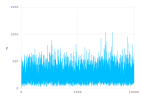

In [30]:
plot(y=κᵤ, Geom.line)

In [31]:
mean(κᵤ)

232.68746755178572

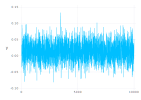

In [32]:
plot(y=μ[1, :], Geom.line)

In [33]:
using Mamba

sim = Chains(
    copy(θ'), 
    names=["κᵤ", "μ1", "μ2", "μ3", "μ4", "μ5", "μ6", "μ7", "μ8", "μ9"]
);

summarystats(sim)

         Mean            SD         Naive SE        MCSE        ESS   
κᵤ 232.68746755179 120.999339981 1.20999339981 2.14485927437 3182.4999
μ1   0.01376047477   0.026593280 0.00026593280 0.00048411407 3017.5078
μ2   0.05412895484   0.027279975 0.00027279975 0.00058672372 2161.8256
μ3   0.04082648384   0.027657954 0.00027657954 0.00055045276 2524.6430
μ4  -0.01806644586   0.024884812 0.00024884812 0.00055527770 2008.3910
μ5  -0.00024189975   0.024225771 0.00024225771 0.00056795879 1819.3722
μ6  -0.02237594516   0.026122262 0.00026122262 0.00058022840 2026.8593
μ7  -0.08792100031   0.028054008 0.00028054008 0.00065367966 1841.8738
μ8  -0.04903342082   0.025208611 0.00025208611 0.00053136384 2250.6805
μ9  -0.05399996118   0.027234463 0.00027234463 0.00056127209 2354.4569

